In [57]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

## Создаем датафрейм

In [58]:
df = pd.read_csv("/content/sample_data/transactions.txt", encoding = 'utf-8', sep = '\t')
df.head()

,Дата продажи,Чек,Клиент,Товар,Товарная группа,Кол-во,Сумма
0,01.09.2017,code000000001,client13166,sku8444,Скобяные изделия,1,29
1,01.09.2017,code000000001,client13166,sku12545,Оборудование для сада и дачи,1,329
2,01.09.2017,code000000001,client13166,sku3391,Инструменты,1,169
3,01.09.2017,code000000001,client13166,sku20444,Инструменты,2,578
4,01.09.2017,code000000002,client1239,sku29959,Скобяные изделия,1,329


In [59]:
print(df.shape)

(1008688, 7)


In [60]:
list(df.columns.values)

['Дата продажи',
 'Чек',
 'Клиент',
 'Товар',
 'Товарная группа',
 'Кол-во',
 'Сумма']

## Группировка: просуммируем продажи товаров в денежном и штучном выражениях

In [61]:
df1 = df.groupby(['Товар'])[['Кол-во', "Сумма"]].sum()
df1

,Кол-во,Сумма
Товар,,
sku1,11,405
sku10,10,17350
sku100,162,47010
sku1000,104,1717
sku10000,77,7447
...,...,...
sku9995,24,47400
sku9996,2,238
sku9997,5,827


# Создадим функцию, которая на вход принимает датасет и считает топ-N товаров

In [62]:
def top_n_items(dataset, N):
  return dataset.sort_values(by='Сумма', ascending=False).head(N)


## Найдем ТОП-N товаров по сумме продаж

In [63]:
top_n_items(df1, int(input()))

10


,Кол-во,Сумма
Товар,,
sku26161,18902,5373638
sku18199,7250,3951361
sku21947,15304,3918570
sku28128,7705,3027786
sku8342,3512,2113158
sku29626,13669,1973964
sku9018,3299,1706341
sku9471,5045,1675843
sku25074,6125,1668585


### Теперь возьмем данные за последние полгода

In [64]:
df['Дата продажи'] = pd.to_datetime(df['Дата продажи'], format='%d.%m.%Y')
max_date = df['Дата продажи'].max()
six_months_ago = max_date - timedelta(days=180)
last_six_months = df[df['Дата продажи'] >= six_months_ago]
last_six_months = last_six_months.groupby(['Товар'])[['Кол-во', "Сумма"]].sum()

## Повторим расчет ТОП-N товаров на данных за полгода

In [65]:
top_n_items(last_six_months, int(input()))

10


,Кол-во,Сумма
Товар,,
sku26161,7889,2350744
sku18199,3055,1843623
sku21947,5736,1521896
sku8342,1500,964572
sku22208,83,838089
sku27791,4374,807938
sku28128,1955,788398
sku9018,1104,654405
sku27161,114,634673


# ABC-XYZ анализ

### Проведем ABC анализ

In [66]:
df1['total'] = df1['Сумма'].sum()
df1['cumsum'] = df1['Сумма'] / df1['total']
df1 = df1.sort_values(by='cumsum', ascending=False)
df1['percentage'] =  round(df1['cumsum'].cumsum() * 100, 2)
df1['category_ABC'] = df1['percentage'].apply(lambda x: 'A' if x <= 80 else ('B' if x <= 95 else 'C'))
df1[['Сумма', 'percentage', 'category_ABC']]

,Сумма,percentage,category_ABC
Товар,,,
sku26161,5373638,0.85,A
sku18199,3951361,1.48,A
sku21947,3918570,2.11,A
sku28128,3027786,2.59,A
sku8342,2113158,2.92,A
...,...,...,...
sku20003,2,100.00,C
sku24554,1,100.00,C
sku25319,1,100.00,C


### Проведем XYZ анализ

In [67]:
df1['cov'] = df.groupby('Товар')['Кол-во'].std() / df.groupby('Товар')['Кол-во'].mean()
df1['category_XYZ'] = pd.cut(df1['cov'], bins=[-1, 0.1, 0.25, float('inf')], labels=['X', 'Y', 'Z'])
df1['category_XYZ'] = df1['category_XYZ'].fillna('X')
df1

,Кол-во,Сумма,total,cumsum,percentage,category_ABC,cov,category_XYZ
Товар,,,,,,,,
sku26161,18902,5373638,628608342,8.548468e-03,0.85,A,1.451809,Z
sku18199,7250,3951361,628608342,6.285887e-03,1.48,A,1.557357,Z
sku21947,15304,3918570,628608342,6.233723e-03,2.11,A,1.018344,Z
sku28128,7705,3027786,628608342,4.816649e-03,2.59,A,2.000747,Z
sku8342,3512,2113158,628608342,3.361645e-03,2.92,A,1.209128,Z
...,...,...,...,...,...,...,...,...
sku20003,2,2,628608342,3.181631e-09,100.00,C,0.000000,X
sku24554,1,1,628608342,1.590816e-09,100.00,C,NaN,X
sku25319,1,1,628608342,1.590816e-09,100.00,C,NaN,X


### Выводим матрицу

In [68]:
result = df1.groupby(['category_ABC', 'category_XYZ']).count()[['Кол-во']]
result = result.rename(columns={'Кол-во': 'Количество товаров'})
result

Количество товаров
category_ABC category_XYZ                    
A            X                           1434
             Y                            390
             Z                           3530
B            X                           2509
             Y                            466
             Z                           5264
C            X                           7525
             Y                            685
             Z                           8763

In [ ]:
df1.groupby(['category_ABC']).count()[['Кол-во']]

,Кол-во
category_ABC,
A,5354
B,8239
C,16973


In [ ]:
df1.groupby(['category_XYZ']).count()[['Кол-во']]

,Кол-во
category_XYZ,
X,11468
Y,1541
Z,17557


Значения совпали

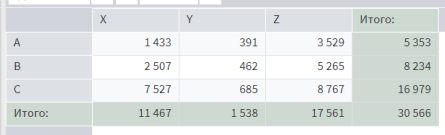

# Разведочный анализ данных

In [69]:
df.describe()

,Дата продажи,Кол-во,Сумма
count,1008688,1.008688e+06,1.008688e+06
mean,2018-12-26 04:42:17.924908544,2.222474e+00,6.231940e+02
min,2017-09-01 00:00:00,0.000000e+00,0.000000e+00
25%,2018-07-23 00:00:00,1.000000e+00,5.600000e+01
50%,2019-02-05 00:00:00,1.000000e+00,1.500000e+02
75%,2019-06-14 00:00:00,2.000000e+00,4.250000e+02
max,2019-10-31 00:00:00,1.100000e+03,2.131770e+05
std,NaN,5.029007e+00,1.878421e+03


In [70]:
df[['Дата продажи']].agg(['count','min','max'])

,Дата продажи
count,1008688
min,2017-09-01 00:00:00
max,2019-10-31 00:00:00


Посмотрим на соотношение товарных групп и диаграммы размаха

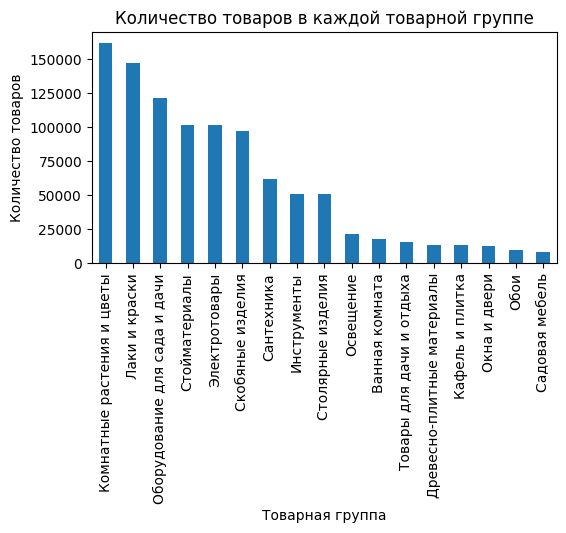

In [71]:
df['Товарная группа'].value_counts().plot(kind='bar', figsize=(6, 3))
plt.title('Количество товаров в каждой товарной группе')
plt.xlabel('Товарная группа')
plt.ylabel('Количество товаров')
plt.show()

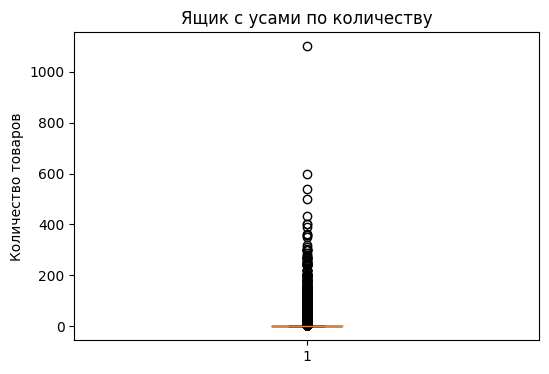

In [72]:
plt.figure(figsize=(6, 4))
plt.boxplot(df['Кол-во'])
plt.title('Ящик с усами по количеству')
plt.ylabel('Количество товаров')
plt.show()

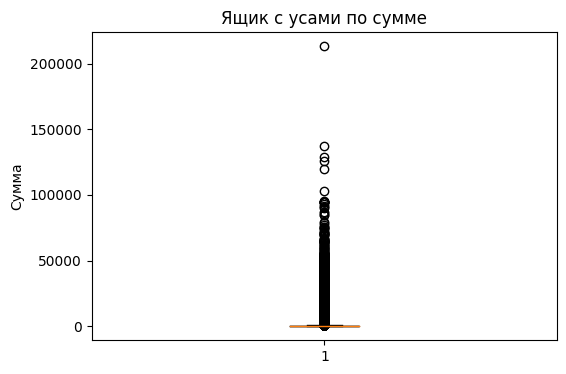

In [73]:
plt.figure(figsize=(6, 4))
plt.boxplot(df['Сумма'])
plt.title('Ящик с усами по сумме')
plt.ylabel('Сумма')
plt.show()

## Видим, что диаграммы размаха очень сжаты. Проверим на выбросы

отфильтруем, у кого в чеке больше 200 товаров

In [74]:
df.loc[(df['Кол-во'] > 200)].head(10)

,Дата продажи,Чек,Клиент,Товар,Товарная группа,Кол-во,Сумма
6301,2017-09-20,code000001619,client9124,sku27292,Стойматериалы,300,2400
25962,2017-11-01,code000006912,client26571,sku17558,Стойматериалы,1100,52800
27196,2017-11-04,code000007262,client20536,sku15736,Сантехника,300,16065
30244,2017-11-06,code000008111,client21035,sku29626,Стойматериалы,240,32232
30568,2017-11-07,code000008201,client6945,sku6611,Столярные изделия,300,7395
31478,2017-11-09,code000008476,client22474,sku17558,Стойматериалы,240,11520
31764,2017-11-10,code000008577,client26571,sku17558,Стойматериалы,600,24480
37596,2017-11-22,code000010285,client16988,sku18190,Стойматериалы,270,27810
118570,2018-03-07,code000028726,client31192,sku27292,Стойматериалы,500,4500
128249,2018-03-16,code000030813,client27519,sku27292,Стойматериалы,300,2700


In [75]:
len(df[(df['Кол-во'] > 200)])

53

Таких чеков 53, а покупки совершены в основном в категориях стройматериалов, скорее всего, это не выброс

### Проверим клиентов. Делаем группировку и строим диаграммы размаха

In [76]:
df2 = df.groupby(['Клиент'])[['Кол-во', 'Сумма']].sum()
df2.head(10)

,Кол-во,Сумма
Клиент,,
client1,9,2273
client10,3,4757
client100,7,8063
client1000,309,44853
client10000,5,8495
client10001,33,1874
client10002,25,5850
client10003,586,57061
client10004,61,9495


In [77]:
df2.describe()

,Кол-во,Сумма
count,42746.000000,4.274600e+04
mean,52.444275,1.470566e+04
std,102.370195,3.264546e+04
min,1.000000,1.000000e+01
25%,7.000000,2.301250e+03
50%,21.000000,6.410000e+03
75%,58.000000,1.623475e+04
max,5457.000000,3.887309e+06


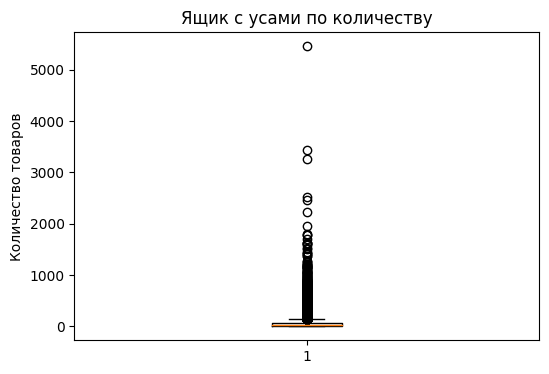

In [78]:
plt.figure(figsize=(6, 4))
plt.boxplot(df2['Кол-во'])
plt.title('Ящик с усами по количеству')
plt.ylabel('Количество товаров')
plt.show()

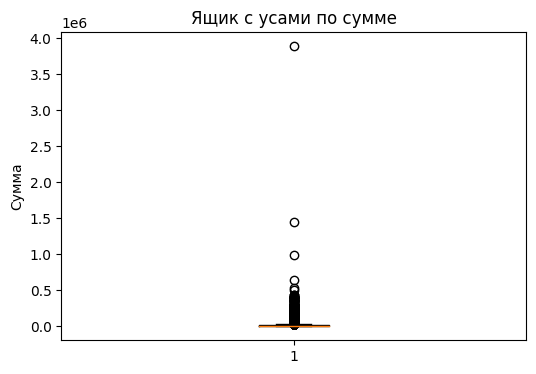

In [79]:
plt.figure(figsize=(6, 4))
plt.boxplot(df2['Сумма'])
plt.title('Ящик с усами по сумме')
plt.ylabel('Сумма')
plt.show()

Хвосты распределения длинные. Это могут быть оптовики, а не типовые клиенты

In [80]:
df2.loc[(df2['Кол-во'] >= 2000) & (df2['Сумма'] >= 500000)]


,Кол-во,Сумма
Клиент,,
client15654,5457,1443255
client29182,3434,3887309
client37582,2526,502515


## Посчитаем одновизитников

In [81]:
visits_count = df.groupby('Клиент')['Дата продажи'].nunique()
single_visit_clients = visits_count[visits_count == 1].index.tolist()
len(single_visit_clients)

12859

### Рассчитаем цену продажи товара в каждой транзакции

In [83]:
f_filtered = df[df['Кол-во'] != 0]
df_filtered = f_filtered.copy()
df_filtered['Цена продажи'] = round(df_filtered['Сумма'] / df_filtered['Кол-во'], 2)
df_filtered.head(10)

,Дата продажи,Чек,Клиент,Товар,Товарная группа,Кол-во,Сумма,Цена продажи
0,2017-09-01,code000000001,client13166,sku8444,Скобяные изделия,1,29,29.0
1,2017-09-01,code000000001,client13166,sku12545,Оборудование для сада и дачи,1,329,329.0
2,2017-09-01,code000000001,client13166,sku3391,Инструменты,1,169,169.0
3,2017-09-01,code000000001,client13166,sku20444,Инструменты,2,578,289.0
4,2017-09-01,code000000002,client1239,sku29959,Скобяные изделия,1,329,329.0
5,2017-09-01,code000000002,client1239,sku19394,Скобяные изделия,4,116,29.0
6,2017-09-01,code000000002,client1239,sku9916,Скобяные изделия,4,116,29.0
7,2017-09-01,code000000002,client1239,sku27003,Скобяные изделия,8,392,49.0
8,2017-09-01,code000000002,client1239,sku15395,Оборудование для сада и дачи,1,47,47.0
9,2017-09-01,code000000002,client1239,sku25185,Ванная комната,1,919,919.0


Рассчитаем простую среднюю цену товара

In [84]:
df_filtered.groupby(['Товар'])[['Цена продажи']].mean()

,Цена продажи
Товар,
sku1,39.062500
sku10,1776.000000
sku100,287.806034
sku1000,16.536585
sku10000,97.720968
...,...
sku9995,1960.600000
sku9996,119.000000
sku9997,165.400000
